# Inception model

In this notebook we trained the inception model using the training and validation set created during preprocessing.

https://towardsdatascience.com/deep-learning-for-time-series-classification-inceptiontime-245703f422db

## Initialization

On Colab upload manually the file `dataset.zip`

In [ ]:
!unzip -o dataset.zip

Archive:  dataset.zip
  inflating: x_train.npy             
  inflating: y_train.npy             
  inflating: x_train_ov.npy          
  inflating: y_train_ov.npy          
  inflating: x_val.npy               
  inflating: y_val.npy               


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing as sklp
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 135 kB 11.2 MB/s 
     |████████████████████████████████| 1.6 MB 44.2 MB/s 


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load dataset

In [ ]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1938, 36, 6), (491, 36, 6), (1938, 12), (491, 12))

## Model

### Definition

In [ ]:
def inception_module(input_tensor, nb_filters=32, kernel_size=41, stride=1, activation='linear'):
        input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(tfk.layers.Conv1D(filters=nb_filters,
                                                 kernel_size=kernel_size_s[i],
                                                 strides=stride, 
                                                 padding='same',
                                                 activation=activation,
                                                 use_bias=False)(input_inception))

        max_pool_1 = tfk.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = tfk.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = tfk.layers.Concatenate(axis=2)(conv_list)
        x = tfk.layers.BatchNormalization()(x)
        x = tfk.layers.Activation(activation='relu')(x)
        return x
  
def shortcut_layer(input_tensor, out_tensor):
        shortcut_y = tfk.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = tfk.layers.BatchNormalization()(shortcut_y)

        x = tfk.layers.Add()([shortcut_y, out_tensor])
        x = tfk.layers.Activation('relu')(x)
        return x

In [ ]:
def build_model(input_shape, nb_classes, depth=6):
  # Define input layer
  input_layer = tfk.layers.Input(input_shape)

  x = input_layer
  input_res = input_layer

  # Add inception modules
  for d in range(depth):

      x = inception_module(x)

      if d % 3 == 2:
          x = shortcut_layer(input_res, x)
          input_res = x

  # Gap
  gap_layer = tfkl.GlobalAveragePooling1D()(x)

  # Output
  output_layer = tfkl.Dense(nb_classes, activation='softmax')(gap_layer)

  model = tfk.models.Model(inputs=input_layer, outputs=output_layer)

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

  return model

In [ ]:
input_shape = x_train.shape[1:]
classes = 12
batch_size = 64
epochs = 200
input_shape, classes


((36, 6), 12)

In [ ]:
model = build_model(input_shape, classes, depth=6)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 max_pooling1d_12 (MaxPooling1D  (None, 36, 6)       0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_52 (Conv1D)             (None, 36, 32)       7872        ['input_3[0][0]']                
                                                                                                  
 conv1d_53 (Conv1D)             (None, 36, 32)       3840        ['input_3[0][0]']            

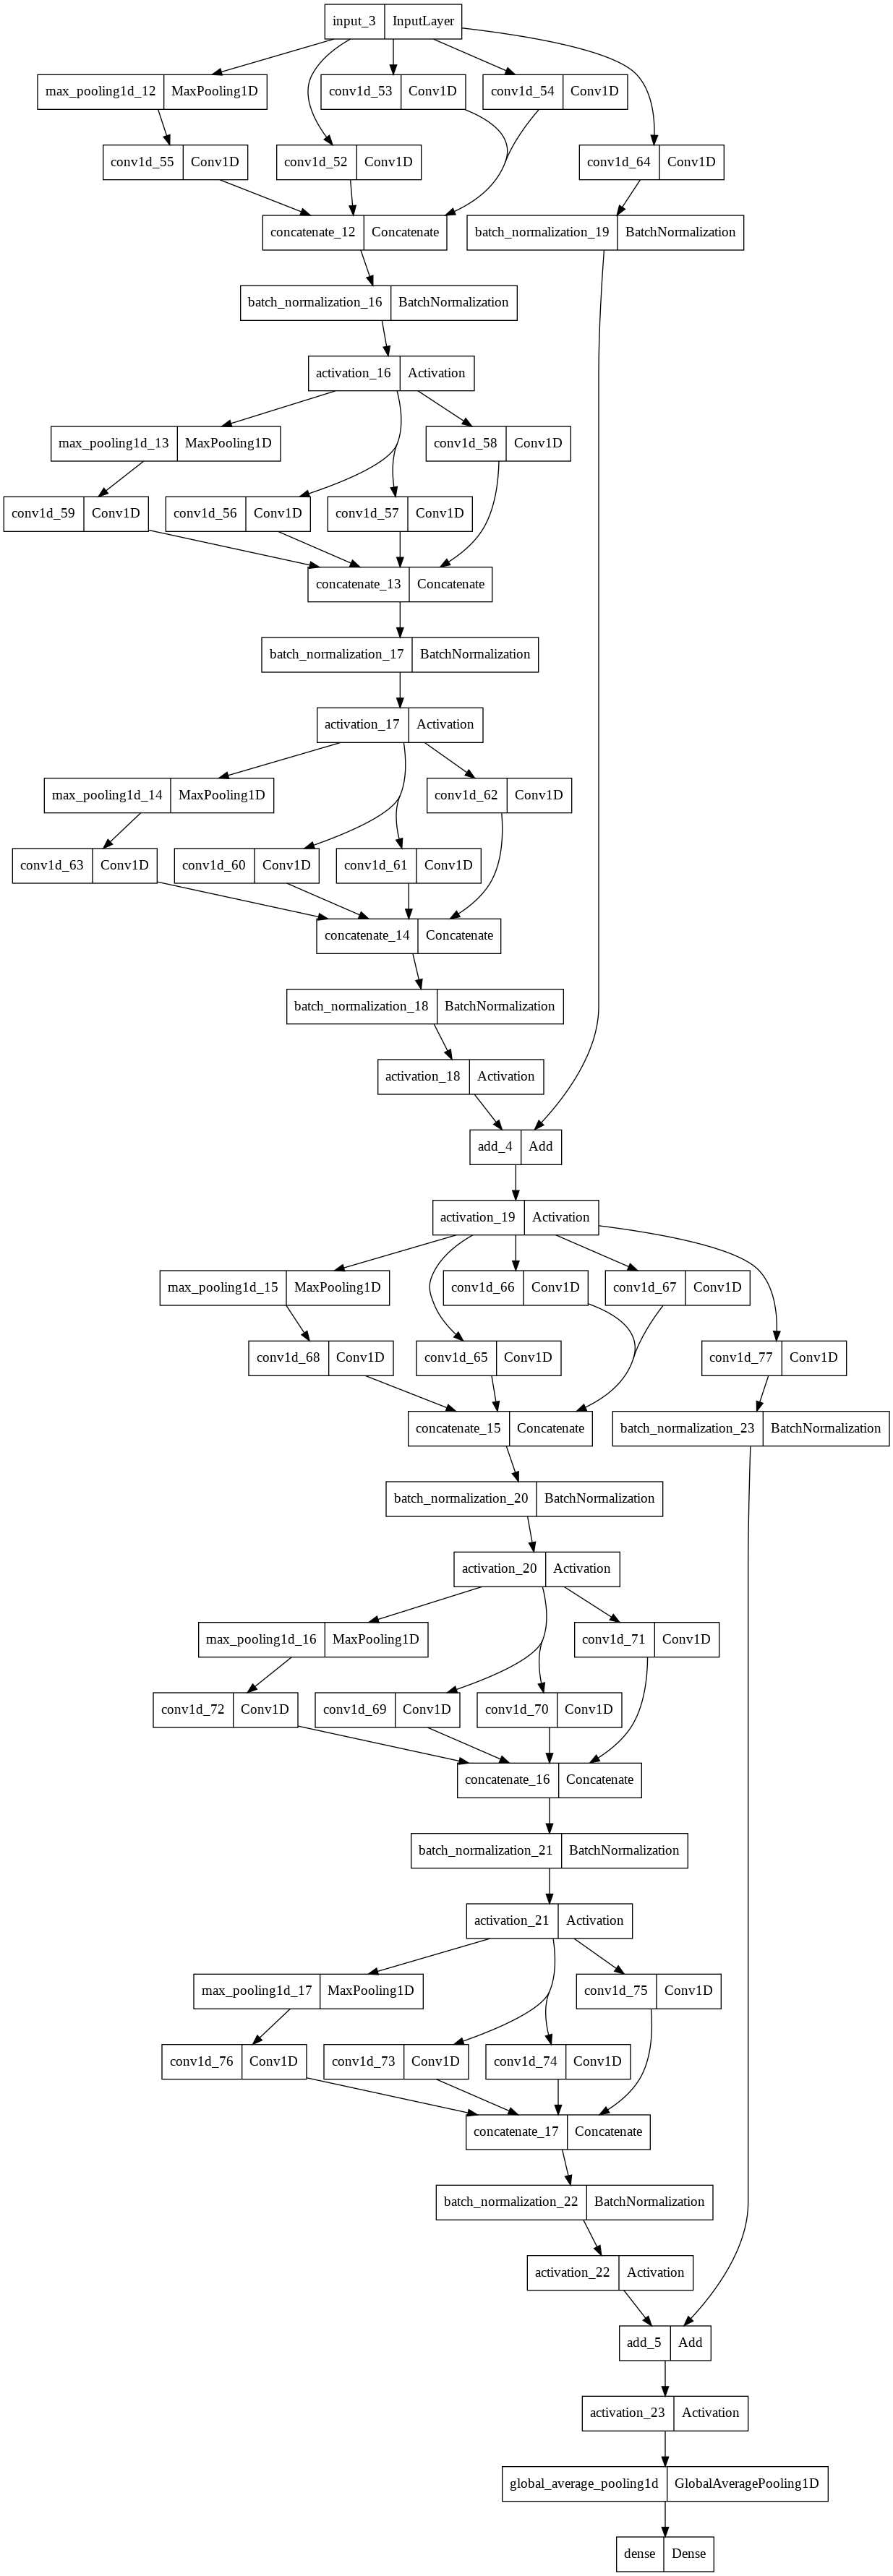

In [ ]:
tfk.utils.plot_model(model)

### Training

In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose = True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, mode='auto',verbose=1, factor=0.01, min_lr=1e-7)
    ]
).history

Epoch 1/200
31/31 [==============================] - 13s 58ms/step - loss: 2.0250 - accuracy: 0.3406 - val_loss: 3.6772 - val_accuracy: 0.3605 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 1s 23ms/step - loss: 1.5630 - accuracy: 0.4830 - val_loss: 1.8193 - val_accuracy: 0.3422 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 1s 22ms/step - loss: 1.4108 - accuracy: 0.5284 - val_loss: 1.9989 - val_accuracy: 0.3360 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 1s 22ms/step - loss: 1.3260 - accuracy: 0.5454 - val_loss: 1.8996 - val_accuracy: 0.3585 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 1s 22ms/step - loss: 1.2595 - accuracy: 0.5562 - val_loss: 1.8601 - val_accuracy: 0.2974 - lr: 0.0010
Epoch 6/200
29/31 [===========================>..] - ETA: 0s - loss: 1.2167 - accuracy: 0.5776
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
31/31 [==============================] - 1s 29ms/ste

### Results

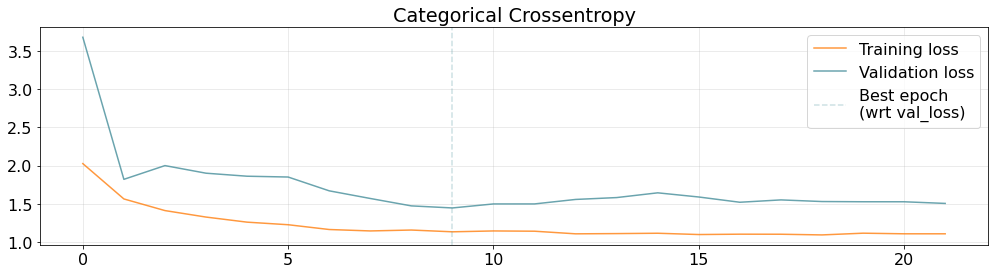

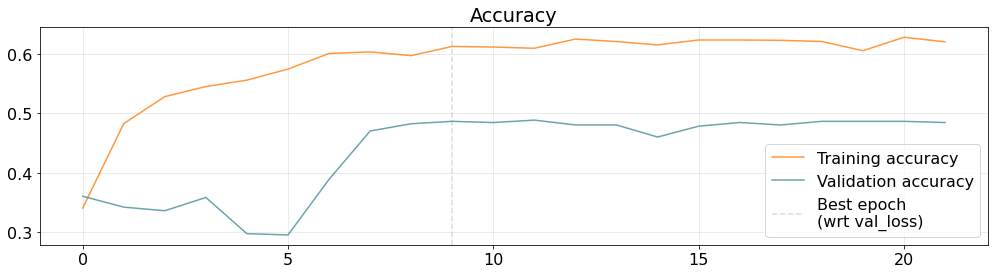

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch\n(wrt val_loss)', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch\n(wrt val_loss)', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.predict(x_val)

16/16 [==============================] - 1s 15ms/step


(491, 12)

In [ ]:
target_categories = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine",
}

In [ ]:
def plot_confusion_matrix(cm, ds_type, labels = list(target_categories.values()) ):
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

Accuracy: 0.4868
Precision: 0.3402
Recall: 0.2976
F1: 0.282


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


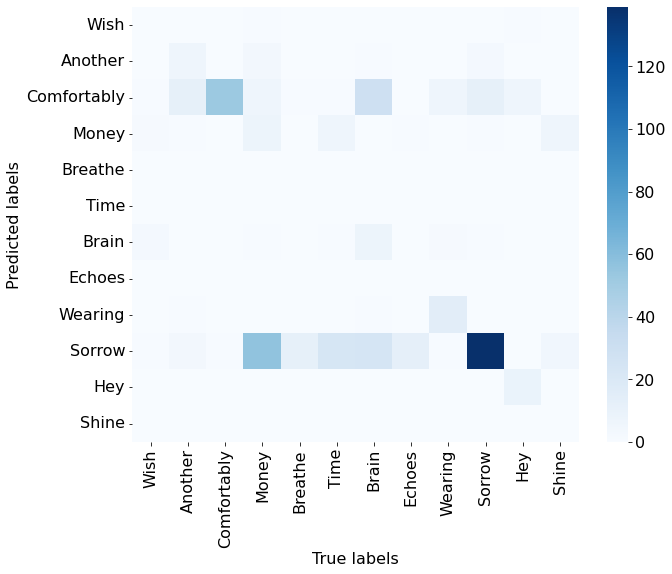

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(target_categories.values()), yticklabels=list(target_categories.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

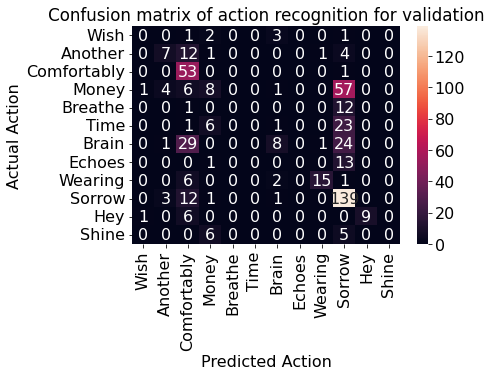

In [ ]:
plot_confusion_matrix(cm, 'validation')

### Save

In [ ]:
model.save("model")
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 91%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model/variables/variables.index (deflated 77%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 95%)
